# Tutorial 04: Dzyaloshinskii-Moriya energy term

> Interactive online tutorial:
> [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ubermag/oommfc/master?filepath=docs%2Fipynb%2Findex.ipynb)

Dzyaloshinskii-Moriya energy density, depending on the crystallographic class, is computed as

$$\mathbf{w_\text{dmi}} = \left\{
\begin{array}{ll}
D \mathbf{m} \cdot (\nabla \times \mathbf{m}), & \text{for}\,\,T(O) \\
D ( \mathbf{m} \cdot \nabla m_{z} - m_{z} \nabla \cdot \mathbf{m}), & \text{for}\,\,C_{nv} \\
D\mathbf{m} \cdot \left( \frac{\partial \mathbf{m}}{\partial x} \times \hat{x} - \frac{\partial \mathbf{m}}{\partial y} \times \hat{y} \right), & \text{for}\,\,D_{2d} \\
\end{array}
\right. $$

where $\mathbf{m}$ is the normalised ($|\mathbf{m}|=1$) magnetisation, and $D$ is the DM energy constant. DMI energy term tends to align neighbouring magnetic moments perpendicular to each other.

In `oommfc`, $\mathbf{m}$ is a part of the magnetisation field `system.m`. Therefore, only DMI energy constant $D$ should be provided as an input parameter to uniquely define the Exchange energy term. $D$ can be constant in space or spatially varying.

## Spatially constant $D$

Let us start by assembling a simple simple simulation where $D$ does not vary in space. The sample is a "one-dimensional" chain of magnetic moments. We are going to choose $C_{nv}$ as the crystallographic class.

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
%matplotlib inline

p1 = (-10e-9, 0, 0)
p2 = (10e-9, 1e-9, 1e-9)
cell = (1e-9, 1e-9, 1e-9)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)

The mesh is

In [2]:
mesh.k3d()

Output()

The system has a Hamiltonian, which consists of only DMI energy term.

In [3]:
D = 1e-3  # Dzyaloshinksii-Moriya energy constant (J/m**2)
system = mm.System(name='dmi_constant_D')
system.energy = mm.DMI(D=D, crystalclass='Cnv')

We are going to minimise the system's energy using `oommfc.MinDriver` later. Therefore, we do not have to define the system's dynamics equation. Finally, we need to define the system's magnetisation (`system.m`). We are going to make it random with $M_\text{s}=8\times10^{5} \,\text{Am}^{-1}$

In [4]:
import random
import discretisedfield as df

Ms = 8e5  # saturation magnetisation (A/m)

def m_fun(pos):
    """Return random 3d vectors for initial random magnetisation"""
    return [2*random.random()-1, 2*random.random()-1, 2*random.random()-1]

system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)

The magnetisation, we have set as initial values looks like:

Output()

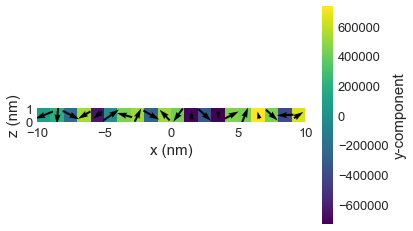

In [5]:
system.m.k3d_vector(color_field=system.m.z)  # k3d plot
system.m.plane('y').mpl()                     # matplotlib plot

Now, we can minimise the system's energy by using `oommfc.MinDriver`.

In [6]:
md = oc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner) [2020/06/12 00:41]... (1.7 s)


We expect that now all magnetic moments are aligned orthogonally to each other.

Output()

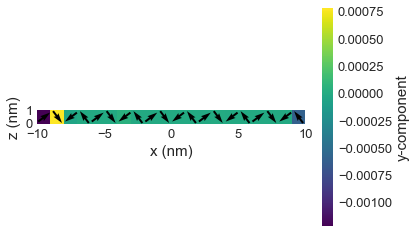

In [7]:
system.m.k3d_vector(color_field=system.m.z)  # k3d plot
system.m.plane('y').mpl()                     # matplotlib plot

## Spatially varying $D$

In the case of DMI, there is only one way how a parameter can be made spatially varying - using a dictionary.

In order to define a parameter using a dictionary, regions must be defined in the mesh. Regions are defined as a dictionary, whose keys are the strings and values are `discretisedfield.Region` objects, which take two corner points of the region as input parameters. 

In [8]:
p1 = (-10e-9, 0, 0)
p2 = (10e-9, 1e-9, 1e-9)
cell = (1e-9, 1e-9, 1e-9)
subregions = {'region1': df.Region(p1=(-10e-9, 0, 0), p2=(0, 1e-9, 1e-9)),
              'region2': df.Region(p1=(0, 0, 0), p2=(10e-9, 1e-9, 1e-9))}
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, subregions=subregions)

The regions we have defined are:

In [9]:
mesh.k3d_subregions()

Output()

Let us say there is no DMI energy ($D=0$) in region 1, whereas in region 2 $D=10^{-3} \,\text{Jm}^{-2}$. Unlike Zeeman and anisotropy energy terms, the DMI energy constant is defined between cells. Therefore, it is necessary to also define the value of $D$ between the two regions. This is achieved by adding another item to the dictionary with key `'region1:region2'`. The object `D` is now defined as a dictionary:

In [10]:
D = {'region1': 0, 'region2': 1e-3, 'region1:region2': 0.5e-3}

The system object is

In [11]:
system = mm.System(name='dmi_dict_D')
system.energy = mm.DMI(D=D, crystalclass='Cnv')
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)

Its initial (and random) magnetisation is

Output()

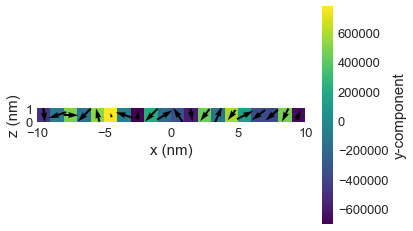

In [12]:
system.m.k3d_vector(color_field=system.m.z)
system.m.plane('y').mpl()

After we minimise the energy

In [13]:
md.drive(system)

Running OOMMF (ExeOOMMFRunner) [2020/06/12 00:41]... (1.8 s)


The magnetisation is as we expected. The magnetisation remains random in region 1, and it is orthogonally aligned in region 2.

Output()

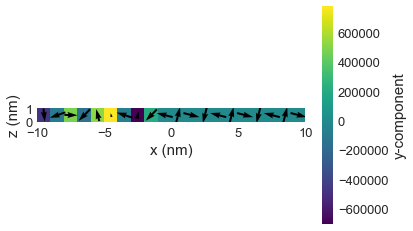

In [14]:
system.m.k3d_vector(color_field=system.m.z)
system.m.plane('y').mpl()